In [1]:
import pandas as pd
import os
#from Preprocessing.params import *


def get_data(LOCAL_FILEPATH):
    data = pd.read_csv(LOCAL_FILEPATH)
    print(f"data acquired with shape {data.shape}")
    return data



#This is the first 2 days worth of data where general_runs stats are all skewed
def remove_221_rows(data):
    data = data[221:]
    print(f"first 221 rows removed. New shape = {data.shape}")
    return data

## Dropping rows if we have no betting data, and imputing if we have some betting data
def dropping_no_betting_data(data):
    data = data.dropna(subset=['f_bsp', 'f_pm_15m', 'f_pm_10m', 'f_pm_05m' , 'f_pm_03m', 'f_pm_02m', 'f_pm_01m'], how='all')
    def impute_row(row):
        row = row.fillna(method='ffill').fillna(method='bfill')
        return row
    columns_to_impute = ['f_bsp', 'f_pm_15m', 'f_pm_10m', 'f_pm_05m', 'f_pm_03m', 'f_pm_02m', 'f_pm_01m']
    data[columns_to_impute] = data[columns_to_impute].apply(impute_row, axis=1)

    #deleting row that has 0s for all odds for some reason


    print(f"Cleaned up missing odds. New shape = {data.shape}")
    return data

def josh_features(data):

    #Creating country feature
    irish_tracks = [
    "SLIGO", "LIMERICK", "NAVAN", "WEXFORD", "CURRAGH",
    "GALWAY", "KILBEGGAN", "GOWRAN PARK", "BELLEWSTOWN",
    "LISTOWEL", "THURLES", "BALLINROBE", "TRAMORE",
    "LEOPARDSTOWN", "DOWN ROYAL", "ROSCOMMON", "CORK",
    "DUNDALK", "KILLARNEY", "LAYTOWN", "TIPPERARY",
    "FAIRYHOUSE", "NAAS", "DOWNPATRICK", "CLONMEL",
    "PUNCHESTOWN"
]

    data['country'] = data['f_track'].apply(lambda x: 'IRE' if x in irish_tracks else 'GB')

    #Completing f_class for Irish races

    # Calculate mean ratings for each 'f_id' group
    mean_ratings_by_id = data.groupby('f_id')['f_rating_or'].mean()

    # Define the mapping of mean ratings to f_class values
    rating_to_f_class_mapping = {
        (96, float('inf')): 1,
        (86, 96): 2,
        (76, 86): 3,
        (66, 76): 4,
        (56, 66): 5,
        (46, 56): 6,
        (-float('inf'), 46): 7
    }

    # Function to map mean ratings to f_class values
    def map_rating_to_f_class(mean_rating):
        for rating_range, f_class_value in rating_to_f_class_mapping.items():
            if rating_range[0] <= mean_rating <= rating_range[1]:
                return f_class_value

    # Apply the mapping to fill NULL values in 'f_class' column based on mean ratings
    data['f_class'] = data.apply(lambda row: map_rating_to_f_class(mean_ratings_by_id.get(row['f_id'])), axis=1)

    # Now the 'f_class' column should be filled based on the specified mapping using mean ratings

    # Merge the mean ratings back into the original DataFrame based on 'f_id'
    data = data.merge(mean_ratings_by_id, how='left', left_on='f_id', right_index=True)

    # Rename the merged mean rating column for clarity
    data.rename(columns={'f_rating_or_y': 'mean_f_rating_or_race', 'f_rating_or_x' : 'f_rating_or' }, inplace=True)

    # Create official rating vs average rating in the race feature
    data['or_rating_vs_avg_race'] = data['f_rating_or'] - data['mean_f_rating_or_race']

    # Create odds percentage and movement features
    data['15m_odds_prob'] = 1 / data['f_pm_15m']
    data['5m_odds_prob'] = 1 / data['f_pm_05m']
    data['15to5m_odds_move_perc'] = (data['5m_odds_prob'] / data['15m_odds_prob'] - 1)
    data['15to5m_odds_move_raw'] = (data['5m_odds_prob'] - data['15m_odds_prob'])
    print(f"Added Josh features. New shape = {data.shape}")
    return data

def class_or_rating_average(data):
    average_or_rating_class = data.groupby("f_class")['f_rating_or'].mean().reset_index()
    average_or_rating_class.rename(columns={'f_rating_or': 'average_or_rating_class'}, inplace=True)
    data = data.merge(average_or_rating_class, on='f_class')
    data['above_below_official_rating_class'] = data['f_rating_or']- data['average_or_rating_class']
    print(f"Added Oli features 2/4. New shape = {data.shape}")
    return data


def oli_features(data):
    data = data.sort_values(by='f_ko')
    data['PreviousPosition'] = data.groupby('f_horse')['f_place'].shift(fill_value=0)

    data = data.sort_values(by=['f_id', 'pred_isp'])
    data['PredictedRank'] = data.groupby('f_id').cumcount() + 1
    print(f"Added Oli features 4/4. New shape = {data.shape}")
    return data

In [2]:
data = get_data("../raw_data/raw_data_v2.2.csv")
data = remove_221_rows(data)
data = dropping_no_betting_data(data)
    #Dropping line that has 0 for all odds
data = data[data.id != 16157910000382]
data = josh_features(data)
data = class_or_rating_average(data)
data = oli_features(data)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/1371766039.py:7: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(LOCAL_FILEPATH)


data acquired with shape (118575, 116)
first 221 rows removed. New shape = (118354, 116)


/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/1371766039.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_impute] = data[columns_to_impute].apply(impute_row, axis=1)


Cleaned up missing odds. New shape = (118093, 116)
Added Josh features. New shape = (118092, 123)
Added Oli features 2/4. New shape = (118092, 125)
Added Oli features 4/4. New shape = (118092, 127)


In [3]:
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

def preprocess_features_v2(data: pd.DataFrame) -> np.ndarray:
    #--------------------------------------------------------------------------#
    print('number of columns: ', len(data.columns))
    ### DROP IRRELEVANT COLUMNS ###
    redundant_columns = [#"id",
                         #"f_id",
                         "f_racetype",
                         #"f_horse",
                         "f_jockey",
                         "f_trainer",
                         "f_rating_hc",
                         "f_lto_pos",
                         "f_bsp",
                         "f_pm_15m",
                         "f_pm_10m",
                         "f_pm_05m",
                         "f_pm_03m",
                         "f_pm_02m",
                         #"f_pm_01m",
                         "f_bsp_p_back",
                         "f_bsp_p_lay",
                         #"f_pm_01m_p_back",
                         "f_pm_01m_p_lay",
                         "f_pm_15m_p_back",
                         "f_pm_15m_p_lay",
                         "general_runs_win_at",
                         "general_runs_win_l200r",
                         "general_runs_win_l50r",
                         "general_runs_win_l16r",
                         "general_runs_at",
                         "general_runs_l200r",
                         "general_runs_l50r",
                         "general_runs_l16r",
                         "sum_bsp_trainer_at",
                         "sum_bsp_jockey_at",
                         "sum_bsp_horse_at",
                         "sum_bsp_trainer_l16r",
                         "sum_bsp_jockey_l16r",
                         "sum_bsp_trainer_l50r",
                         "sum_bsp_jockey_l50r",
                         "sum_bsp_trainer_l200r",
                         "sum_bsp_jockey_l200r",
                         "sum_bsp_horse_l10r",
                         "sum_bsp_horse_l5r",
                         "sum_bsp_horse_l2r",
                         "15to5m_odds_move_perc",
                         "15to5m_odds_move_raw",
                         "15m_odds_prob",
                         "5m_odds_prob"]
    data.drop(columns = redundant_columns, inplace = True)
    print("✅ DROPPED IRRELEVANT COLUMNS")

    #--------------------------------------------------------------------------#

    ### DROP ROWS WITH NULL VALUES IN THESE COLUMNS ###
    data.dropna(axis = 0, inplace = True,
                subset = ["f_pace",
                          "f_stall",
                          "stall_position",
                          "f_going",
                          "f_rating_or",
                          "or_rating_vs_avg_race",
                          "country",
                          "mean_f_rating_or_race",
                          "f_class",
                          "average_or_rating_class",
                          "above_below_official_rating_class",
                          "PreviousPosition",
                          "PredictedRank",
                          ])
    print("✅ DROPPED ROWS WITH NULL VALUES")

    #--------------------------------------------------------------------------#

    ### STRIP SURROUNDING WHITESPACE ###
    data['f_track'] = data['f_track'].str.strip()
    print("✅ WHITESPACE STRIPPED FROM 'f_track'")

    #--------------------------------------------------------------------------#

    ### CONVERT ODDS TO PROBABILITY ###
    def odds_to_prob(x):
        return 1/x
    data['pred_isp'] = data['pred_isp'].apply(odds_to_prob)
    print("✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)")

    #--------------------------------------------------------------------------#

    ### CODE WINNERS AS '1', REST AS '0' ###
    def winner(x):
        if x == 1:
            return 1
        else:
            return 0
    data['f_place'] = data['f_place'].apply(winner)
    print("✅ WINNERS CODED AS '1', REST '0'")

    #--------------------------------------------------------------------------#

    ### 'f_ko' CONVERTED TO DATETIME ###
    data['f_ko'] = data['f_ko'].astype('datetime64[ns]')
    print("✅ 'f_ko' CONVERTED TO DATETIME")

    #--------------------------------------------------------------------------#

    ### ENCODE THE GOING (GROUND CONDITION) ###
    def f_going_coder(x):
        if x == 'FRM':
            return 1
        elif x == 'GTF':
            return 2
        elif x == 'GD' or x == 'GTY' or x == 'STD':
            return 3
        elif x == 'YLD' or x == 'YTS' or x == 'STSL' or x == 'GTS':
            return 4
        elif x == 'SFT':
            return 5
        elif x == 'HVY' or x == 'HTS':
            return 6
    data['f_going'] = data['f_going'].apply(f_going_coder)
    print("✅ TRACK CONDITIONS ORDINALLY ENCODED")

    #--------------------------------------------------------------------------#

    ### MINMAX SCALE NUMERIC FEATURES ###
    set_config(transform_output = "pandas")
    numeric_features = ["f_going",
                        "average_or_rating_class",
                        "above_below_official_rating_class",
                        "PreviousPosition",
                        "PredictedRank",
                        "f_distance",
                        "f_class",
                        "f_age",
                        "f_pace",
                        "f_weight",
                        "f_runners",
                        "f_rating_or",
                        "mean_f_rating_or_race",
                        "or_rating_vs_avg_race",
                        "f_rating_rbd",
                        "f_stall",
                        "stall_position",
                        "trainer_runs_win_at",
                        "trainer_runs_win_l200r",
                        "trainer_runs_win_l50r",
                        "trainer_runs_win_l16r",
                        "trainer_runs_at",
                        "trainer_runs_l200r",
                        "trainer_runs_l50r",
                        "trainer_runs_l16r",
                        "jockey_runs_win_at",
                        "jockey_runs_win_l200r",
                        "jockey_runs_win_l50r",
                        "jockey_runs_win_l16r",
                        "jockey_runs_at",
                        "jockey_runs_l200r",
                        "jockey_runs_l50r",
                        "jockey_runs_l16r",
                        "horse_runs_win_at",
                        "horse_runs_win_l10r",
                        "horse_runs_win_l5r",
                        "horse_runs_win_l2r",
                        "horse_runs_at",
                        "horse_runs_l10r",
                        "horse_runs_l5r",
                        "horse_runs_l2r",
                        "iv_horse_at",
                        "iv_trainer_l200r",
                        "iv_trainer_l50r",
                        "iv_trainer_l16r",
                        "iv_trainer_at",
                        "iv_jockey_l200r",
                        "iv_jockey_l50r",
                        "iv_jockey_l16r",
                        "iv_jockey_at",
                        "ae_horse_l10r",
                        "ae_horse_l5r",
                        "ae_horse_l2r",
                        "ae_horse_at",
                        "ae_trainer_l200r",
                        "ae_trainer_l50r",
                        "ae_trainer_l16r",
                        "ae_trainer_at",
                        "ae_jockey_l200r",
                        "ae_jockey_l50r",
                        "ae_jockey_l16r",
                        "ae_jockey_at",
                        "rolling_avg_trainer_finish_at",
                        "rolling_avg_trainer_finish_l200r",
                        "rolling_avg_trainer_finish_l50r",
                        "rolling_avg_trainer_finish_l16r",
                        "rolling_avg_horse_finish_at",
                        "rolling_avg_horse_finish_l10r",
                        "rolling_avg_horse_finish_l5r",
                        "rolling_avg_horse_finish_l2r",
                        "rolling_avg_jockey_finish_at",
                        "rolling_avg_jockey_finish_l200r",
                        "rolling_avg_jockey_finish_l50r",
                        "rolling_avg_jockey_finish_l16r",
                        ]
    numeric_transformer = Pipeline(
        steps=[("scaler", MinMaxScaler())])
    print("✅ NUMERIC FEATURES MINMAX-SCALED")

    #--------------------------------------------------------------------------#

    ### IMPUTE HEADGEAR NULLS WITH 'no_headgear' ###
    headgear_feature = ["f_headgear"]
    headgear_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'constant',
                                         fill_value = 'no_headgear'))])
    print("✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'")

    #--------------------------------------------------------------------------#

    ### MEAN IMPUTE CERTAIN FEATURES ###
    mean_impute_features = ["f_dob", "f_prb_avg"]
    mean_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'mean'))])
    print("✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'")

    #--------------------------------------------------------------------------#

    ### IMPUTE NULLS WITH 0's ###
    zero_impute_features = ["f_rating_rbd",
                            "trainer_runs_win_at",
                            "trainer_runs_win_l200r",
                            "trainer_runs_win_l50r",
                            "trainer_runs_win_l16r",
                            "trainer_runs_at",
                            "trainer_runs_l200r",
                            "trainer_runs_l50r",
                            "trainer_runs_l16r",
                            "jockey_runs_win_at",
                            "jockey_runs_win_l200r",
                            "jockey_runs_win_l50r",
                            "jockey_runs_win_l16r",
                            "jockey_runs_at",
                            "jockey_runs_l200r",
                            "jockey_runs_l50r",
                            "jockey_runs_l16r",
                            "horse_runs_win_at",
                            "horse_runs_win_l10r",
                            "horse_runs_win_l5r",
                            "horse_runs_win_l2r",
                            "horse_runs_at",
                            "horse_runs_l10r",
                            "horse_runs_l5r",
                            "horse_runs_l2r",
                            "iv_horse_at",
                            "iv_trainer_l200r",
                            "iv_trainer_l50r",
                            "iv_trainer_l16r",
                            "iv_trainer_at",
                            "iv_jockey_l200r",
                            "iv_jockey_l50r",
                            "iv_jockey_l16r",
                            "iv_jockey_at",
                            "ae_horse_l10r",
                            "ae_horse_l5r",
                            "ae_horse_l2r",
                            "ae_horse_at",
                            "ae_trainer_l200r",
                            "ae_trainer_l50r",
                            "ae_trainer_l16r",
                            "ae_trainer_at",
                            "ae_jockey_l200r",
                            "ae_jockey_l50r",
                            "ae_jockey_l16r",
                            "ae_jockey_at",
                            "rolling_avg_trainer_finish_at",
                            "rolling_avg_trainer_finish_l200r",
                            "rolling_avg_trainer_finish_l50r",
                            "rolling_avg_trainer_finish_l16r",
                            "rolling_avg_horse_finish_at",
                            "rolling_avg_horse_finish_l10r",
                            "rolling_avg_horse_finish_l5r",
                            "rolling_avg_horse_finish_l2r",
                            "rolling_avg_jockey_finish_at",
                            "rolling_avg_jockey_finish_l200r",
                            "rolling_avg_jockey_finish_l50r",
                            "rolling_avg_jockey_finish_l16r"]
    zero_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'constant',
                                         fill_value = 0))])
    print("✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES")

    #--------------------------------------------------------------------------#

    ### O.H.E. CATEGORICAL FEATURES ###
    categorical_features = ["f_track", "f_headgear", "country"]
    categorical_transformer = Pipeline(
        steps=[("encoder", OneHotEncoder(handle_unknown="ignore",
                                     sparse_output=False))])
    print("✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)")

    #--------------------------------------------------------------------------#

    ### COLUMN TRANSFORMER ###
    ct1 = ColumnTransformer(
        transformers=[("zero_imputer", zero_imputer, zero_impute_features),
                      ("headgear_imputer", headgear_imputer, headgear_feature),
                      ("mean_imputer", mean_imputer, mean_impute_features),
                      ],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    ct1_processed = ct1.fit_transform(data)

    print('number of columns: ', len(ct1_processed.columns))

    ct2 = ColumnTransformer(
        transformers=[("cat", categorical_transformer, categorical_features)],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    ct2_processed = ct2.fit_transform(ct1_processed)

    ct3 = ColumnTransformer(
        transformers=[("scale", numeric_transformer, numeric_features),],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    print("✅ COLUMN TRANSFORMER ASSEMBLED")

    #--------------------------------------------------------------------------#

    ### FIT_TRANSFORM FEATURES ###
    print("⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...")
    data_processed = ct3.fit_transform(ct2_processed)
    print('number of columns: ', len(data_processed.columns))
    print("✅ DATA PROCESSED WITH SHAPE:", data_processed.shape)

    return data_processed

In [4]:
data = preprocess_features_v2(data)

number of columns:  127
✅ DROPPED IRRELEVANT COLUMNS
✅ DROPPED ROWS WITH NULL VALUES
✅ WHITESPACE STRIPPED FROM 'f_track'
✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)
✅ WINNERS CODED AS '1', REST '0'
✅ 'f_ko' CONVERTED TO DATETIME
✅ TRACK CONDITIONS ORDINALLY ENCODED
✅ NUMERIC FEATURES MINMAX-SCALED
✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'
✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'
✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES
✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)
number of columns:  87
✅ COLUMN TRANSFORMER ASSEMBLED
⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...
number of columns:  163
✅ DATA PROCESSED WITH SHAPE: (117467, 163)


In [5]:
data.isnull().sum()

f_going                                0
average_or_rating_class                0
above_below_official_rating_class      0
PreviousPosition                       0
PredictedRank                          0
                                    ... 
f_horse                                0
pred_isp                               0
f_place                                0
f_pm_01m                               0
f_pm_01m_p_back                      145
Length: 163, dtype: int64

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
data = data.reset_index(drop=True)

In [8]:
backtest = data[['f_ko','f_id', 'id','f_horse','f_pm_01m', 'f_pm_01m_p_back']]

In [114]:
backtest

,f_ko,f_id,id,f_horse,f_pm_01m,f_pm_01m_p_back
0,2021-03-06 01:25:00,16149939000030,16149939000396,Tone The Barone,2.28,-1.00
1,2021-03-06 01:25:00,16149939000030,16149939000058,Blue De Vega,10.00,-1.00
2,2021-03-06 01:25:00,16149939000030,16149939000232,Lihou,5.60,-1.00
3,2021-03-06 01:25:00,16149939000030,16149939000290,Ornate,11.50,9.98
4,2021-03-06 01:25:00,16149939000030,16149939000184,Han Solo Berger,17.50,-1.00
...,...,...,...,...,...,...
117462,2023-08-20 18:45:00,16925535000012,16925535000107,Dark Island,6.80,-1.00
117463,2023-08-20 18:45:00,16925535000012,16925535000404,Traila,13.00,11.40
117464,2023-08-20 18:45:00,16925535000012,16925535000015,Alpine Stroll,10.50,-1.00
117465,2023-08-20 18:45:00,16925535000012,16925535000353,Saratoga Gold,17.50,-1.00


In [9]:
y = data['f_place']

In [10]:
X = data.drop(columns=['f_pm_01m', 'f_pm_01m_p_back' , 'f_place', 'f_id', 'id', 'f_horse',
                       'trainer_runs_l200r', 'trainer_runs_l50r', 'trainer_runs_l16r',
                       'jockey_runs_l200r', 'jockey_runs_l50r', 'jockey_runs_l16r',
                      'horse_runs_l10r', 'horse_runs_l5r', 'horse_runs_l2r'])

In [11]:
print(data.shape)
print(X.shape)
print(y.shape)
print(backtest.shape)

(117467, 163)
(117467, 148)
(117467,)
(117467, 6)


Data start: Row 0: 2021-03-06 01:25:00. 
Start of year 2: Row 45648:  2022-03-07 17:30:00.    
Start of year 3: Row 91429: 2023-03-06 16:55:00  

In [12]:
X_train = X.iloc[:45648]
X_val = X.iloc[45648:91429]
X_test = X.iloc[91429:]
y_train = y.iloc[:45648]
y_val = y.iloc[45648:91429]
y_test = y.iloc[91429:]
backtest_train = backtest.iloc[:45648]
backtest_val = backtest.iloc[45648:91429]
backtest_test = backtest.iloc[91429:]

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(backtest_train.shape)
print(backtest_val.shape)
print(backtest_test.shape)

(45648, 148)
(45781, 148)
(26038, 148)
(45648,)
(45781,)
(26038,)
(45648, 6)
(45781, 6)
(26038, 6)


In [14]:
from sklearn.decomposition import PCA
X_train_PCA = X_train.drop(columns=['f_ko'])
X_val_PCA = X_val.drop(columns=['f_ko'])
X_test_PCA = X_test.drop(columns=['f_ko'])


In [15]:
pca = PCA()
pca.fit(X_train_PCA)

PCA()

In [16]:
horse_features = X_train_PCA.columns

# Access our 157 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=horse_features,
                 columns=[f'PC{i}' for i in range(1, 148)])
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147
f_going,-0.001316,-0.000747,0.025684,-0.056321,0.046340,-0.086143,-0.008367,-0.008744,-0.165388,0.015656,-0.228597,0.257111,-0.049808,0.017990,-0.013089,0.007658,0.035502,0.061050,0.352886,0.432411,-0.244749,0.017671,-0.048272,-0.391070,0.116191,-0.088240,0.115315,-0.057571,0.166916,0.000097,-0.023321,0.151649,-0.003500,-0.120145,0.014083,-0.047118,-0.069062,-0.004468,0.087781,-0.111411,0.035057,0.214189,0.013191,-0.050331,-0.062487,-0.062712,-0.054149,-0.025406,-0.058606,0.083005,-0.024036,-0.212534,-0.122287,0.006615,-0.007675,0.011771,-0.038866,-0.065542,0.038126,0.037235,-0.107880,-0.035577,0.056089,-0.026691,-0.073148,-0.024139,-0.003198,0.012030,-0.006050,-0.007328,-0.009482,-0.012444,-0.005291,0.006904,0.010985,0.001530,0.019365,0.023489,-0.057021,0.005463,-0.028316,-0.016064,0.058260,0.004378,0.012045,-0.009778,0.007588,0.014747,-0.001071,-0.011537,-0.001713,-0.004512,0.007803,0.002176,-0.005295,0.004192,0.016960,0.008967,0.000233,0.000080,-0.000841,0.001106,0.000579,0.000294,-0.004626,-0.001138,-0.001723,-0.000205,-0.001632,-0.000104,-0.000952,-0.003177,-0.000652,0.001179,0.000407,0.000067,-0.000263,0.000152,0.001370,-0.000224,0.000231,0.000397,-0.000108,0.000307,-0.000114,0.000062,-0.000181,-0.000226,0.000161,0.000002,0.000164,2.811439e-04,-0.000007,0.000033,-0.000045,0.000015,1.593201e-06,-7.005342e-07,5.473100e-15,-3.877446e-16,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00
average_or_rating_class,-0.108582,0.361668,0.174284,-0.301243,0.099034,0.100201,0.072395,-0.039580,0.040104,0.036405,-0.001863,0.009517,-0.038602,0.020833,0.014965,-0.061348,-0.035983,-0.008881,0.028756,-0.028489,-0.010110,0.036970,0.018481,0.010614,-0.012196,0.042244,-0.032959,-0.022957,-0.037218,-0.023885,-0.002062,0.032486,0.040660,0.001464,-0.003306,0.034228,-0.003400,-0.000291,0.009679,-0.020277,-0.027335,-0.005208,-0.022749,0.065575,0.049851,-0.002220,0.003602,-0.009839,-0.013087,0.022353,-0.019598,-0.015219,0.010184,-0.007006,0.001195,0.002612,0.012415,0.010355,-0.007673,0.008924,0.029834,-0.063324,0.033574,0.012243,-0.014125,-0.028605,-0.004773,0.004319,-0.012097,-0.008043,0.013704,0.025206,0.010312,0.040878,0.014108,-0.013840,0.008196,0.031890,-0.007103,0.013568,0.019047,0.033472,-0.072020,0.002988,0.109259,-0.008161,0.115725,0.000034,0.008936,-0.000833,0.006597,0.002088,0.108254,0.053098,-0.153903,-0.018381,-0.009092,0.046180,-0.010298,0.019098,-0.004024,0.021265,-0.046277,-0.087444,0.026134,-0.028678,0.155670,0.001852,-0.008351,0.003279,-0.002408,0.001776,-0.001135,-0.000857,0.005981,-0.004569,-0.001180,-0.002205,-0.002283,0.000681,0.011707,0.002380,0.010478,0.673169,0.011866,0.013206,-0.005825,-0.001646,0.000197,0.000537,0.001547,5.155154e-04,0.000251,0.000240,-0.000717,0.000046,-1.043029e-04,6.534964e-05,-3.172780e-01,-3.465755e-04,4.581522e-04,-1.538665e-04,9.516140e-07,1.906263e-06,5.481856e-18,-1.181421e-17,2.489032e-18
above_below_official_rating_class,-0.004096,0.011194,0.000007,0.008538,-0.010381,-0.004009,-0.007758,0.001717,0.002835,-0.007048,0.001966,-0.006999,-0.007183,-0.000570,-0.004554,0.005965,0.010697,0.006007,0.001316,0.010664,0.004089,-0.001572,-0.003117,-0.029490,0.001095,-0.011501,-0.029195,0.037452,0.035308,

In [17]:
#pd.set_option('display.max_rows', None)

Text(0, 0.5, 'Explained variance')

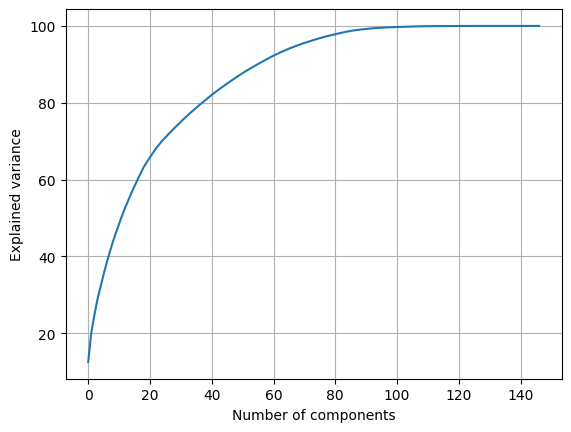

In [18]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [41]:
pca_80 = PCA(n_components = 80)
pca_80.fit(X_train_PCA)

PCA(n_components=80)

In [42]:
train_features_reduced = pca_80.transform(X_train_PCA)
val_features_reduced = pca_80.transform(X_val_PCA)
test_features_reduced = pca_80.transform(X_test_PCA)

# verify shape after PCA
print("Train features shape:", train_features_reduced.shape)
print("Val features shape:", val_features_reduced.shape)
print("Test features shape: ", test_features_reduced.shape)

# get exact variability retained
print("\nVar retained (%):", 
      np.sum(pca_80.explained_variance_ratio_ * 100))

Train features shape: (45648, 80)
Val features shape: (45781, 80)
Test features shape:  (26038, 80)

Var retained (%): 97.66079096973375


In [79]:
# convert labels to a one-hot vector
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

# define network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Accuracy, Recall

MLP = Sequential()
MLP.add(InputLayer(input_shape=(80, ))) # input layer
MLP.add(Dense(64, activation='relu')) # hidden layer 2
MLP.add(Dense(32, activation='relu')) # hidden layer 2
MLP.add(Dense(1, activation='sigmoid')) # output layer



In [95]:
# optimization
MLP.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=[Precision()])

In [96]:
from tensorflow.keras.callbacks import EarlyStopping
# train (fit)

#es = EarlyStopping(patience=20, restore_best_weights=True)

history = MLP.fit(train_features_reduced, y_train, 
                  epochs=20, batch_size=128, verbose=1,
                  validation_data=(val_features_reduced, y_val))

Epoch 1/20
357/357 [==============================] - 0s 900us/step - loss: 0.2826 - precision_8: 0.6448 - val_loss: 0.3188 - val_precision_8: 0.3258
Epoch 2/20
357/357 [==============================] - 0s 731us/step - loss: 0.2811 - precision_8: 0.6404 - val_loss: 0.3215 - val_precision_8: 0.3155
Epoch 3/20
357/357 [==============================] - 0s 736us/step - loss: 0.2797 - precision_8: 0.6577 - val_loss: 0.3219 - val_precision_8: 0.2513
Epoch 4/20
357/357 [==============================] - 0s 745us/step - loss: 0.2785 - precision_8: 0.6606 - val_loss: 0.3236 - val_precision_8: 0.3180
Epoch 5/20
357/357 [==============================] - 0s 746us/step - loss: 0.2774 - precision_8: 0.6653 - val_loss: 0.3255 - val_precision_8: 0.2759
Epoch 6/20
357/357 [==============================] - 0s 734us/step - loss: 0.2761 - precision_8: 0.6579 - val_loss: 0.3261 - val_precision_8: 0.2911
Epoch 7/20
357/357 [==============================] - 0s 744us/step - loss: 0.2749 - precision_8: 0.

In [97]:
# evaluate performance on test data
test_loss, test_acc = MLP.evaluate(test_features_reduced, y_test,
                                         batch_size=128,
                                         verbose=1)
print("Test loss:", test_loss)
print("Test precision:", test_acc)

204/204 [==============================] - 0s 294us/step - loss: 0.3579 - precision_8: 0.2284
Test loss: 0.3579474687576294
Test precision: 0.2284069061279297


In [98]:
y_pred = MLP.predict(test_features_reduced)

814/814 [==============================] - 0s 225us/step


In [99]:
y_pred

array([[0.03472102],
       [0.11404639],
       [0.01349043],
       ...,
       [0.00542138],
       [0.03332681],
       [0.12886587]], dtype=float32)

<Axes: ylabel='Count'>

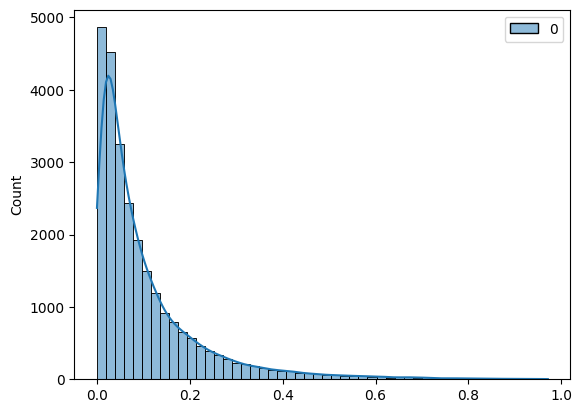

In [100]:
import seaborn as sns
sns.histplot(y_pred, bins = 50, kde=True)

In [101]:
y_pred

array([[0.03472102],
       [0.11404639],
       [0.01349043],
       ...,
       [0.00542138],
       [0.03332681],
       [0.12886587]], dtype=float32)

In [102]:
backtest_test['model_preds'] = y_pred

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/1787826085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_preds'] = y_pred


In [103]:
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/689424641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']


In [104]:
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/4042348346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']


In [105]:
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_16820/1950861892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']


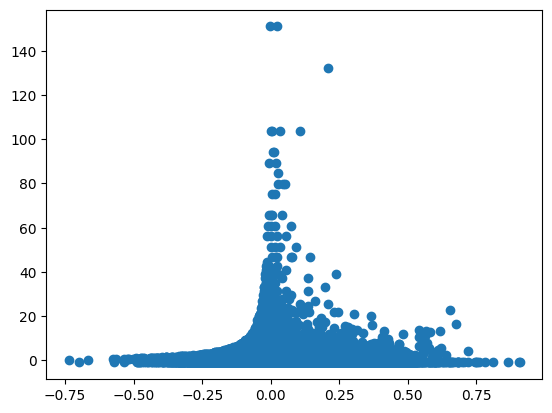

In [106]:
plt.scatter(backtest_test['model_edge_basic'], backtest_test['f_pm_01m_p_back'])

In [107]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[backtest_test['model_edge_basic'] >= 0]
above5 = backtest_test[backtest_test['model_edge_basic'] >= 0.05]
above10 = backtest_test[backtest_test['model_edge_basic'] >= 0.1]
above15 = backtest_test[backtest_test['model_edge_basic'] >= 0.15]
above20 = backtest_test[backtest_test['model_edge_basic'] >= 0.20]
above30 = backtest_test[backtest_test['model_edge_basic'] >= 0.30]

In [108]:
# Calculate evolutions of profits for each threshold

dfall = all_bets.sort_values(by='f_ko')
dfall['cumulative_profit'] = dfall['f_pm_01m_p_back'].cumsum()

df0 = above0.sort_values(by='f_ko')
df0['cumulative_profit'] = df0['f_pm_01m_p_back'].cumsum()

df5 = above5.sort_values(by='f_ko')
df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()

df10 = above10.sort_values(by='f_ko')
df10['cumulative_profit'] = df10['f_pm_01m_p_back'].cumsum()

df15 = above15.sort_values(by='f_ko')
df15['cumulative_profit'] = df15['f_pm_01m_p_back'].cumsum()

df20 = above20.sort_values(by='f_ko')
df20['cumulative_profit'] = df20['f_pm_01m_p_back'].cumsum()

df30 = above30.sort_values(by='f_ko')
df30['cumulative_profit'] = df30['f_pm_01m_p_back'].cumsum()




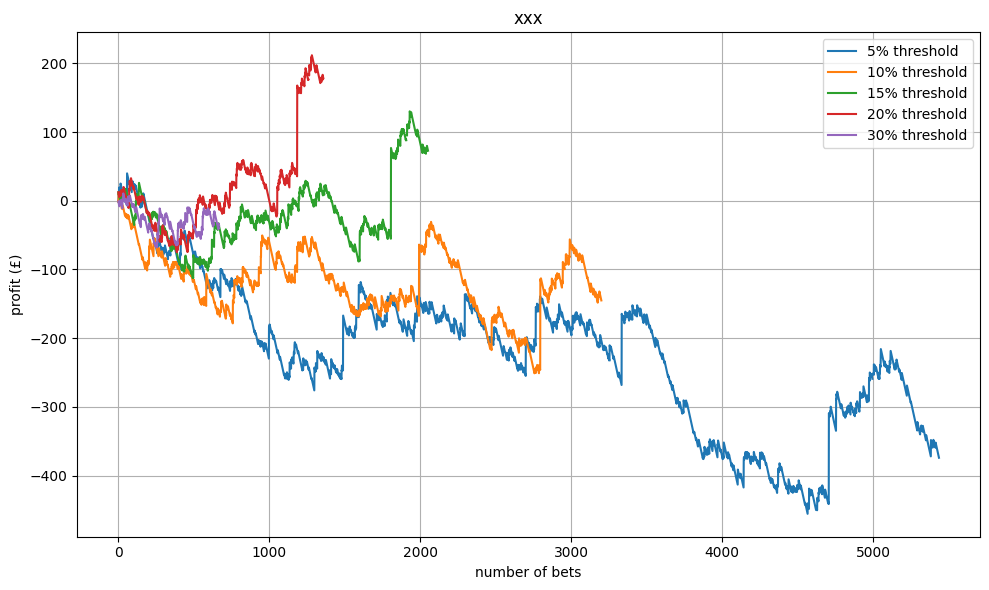

In [109]:
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='0% threshold')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='5% threshold')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='10% threshold')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='15% threshold')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='20% threshold')
plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='30% threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
print("df5")
print(int(df5['f_pm_01m_p_back'].count())), print(int(df5['f_pm_01m_p_back'].sum())), print(int(df5['f_pm_01m_p_back'].sum())/(int(df5['f_pm_01m_p_back'].count())))
print("------")
print("df10")
print(int(df10['f_pm_01m_p_back'].count())), print(int(df10['f_pm_01m_p_back'].sum())), print(int(df10['f_pm_01m_p_back'].sum())/(int(df10['f_pm_01m_p_back'].count())))
print("------")
print("df15")
print(int(df15['f_pm_01m_p_back'].count())), print(int(df15['f_pm_01m_p_back'].sum())), print(int(df15['f_pm_01m_p_back'].sum())/(int(df15['f_pm_01m_p_back'].count())))
print("------")
print("df20")
print(int(df20['f_pm_01m_p_back'].count())), print(int(df20['f_pm_01m_p_back'].sum())), print(int(df20['f_pm_01m_p_back'].sum())/(int(df20['f_pm_01m_p_back'].count())))
print("------")
print("df30")
print(int(df30['f_pm_01m_p_back'].count())), print(int(df30['f_pm_01m_p_back'].sum())), print(int(df30['f_pm_01m_p_back'].sum())/(int(df30['f_pm_01m_p_back'].count())))
print("------")

df5
5425
-373
-0.0687557603686636
------
df10
3193
-145
-0.04541183839649233
------
df15
2048
72
0.03515625
------
df20
1357
178
0.131171702284451
------
df30
667
-35
-0.05247376311844078
------


df5
4444
-187
-0.04207920792079208
------
df10
1847
-35
-0.018949648077964266
------
df15
901
-54
-0.05993340732519423
------
df20
437
-58
-0.13272311212814644
------
df30
99
3
0.030303030303030304
------

In [ ]:
# Create dataframes of horses above specific proba_difference thresholds

all_betsb = backtest_test
above0b = backtest_test[backtest_test['model_edge_proportionate'] >= 1]
above5b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.2]
above10b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.4]
above15b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.6]
above20b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.8]
above30b = backtest_test[backtest_test['model_edge_proportionate'] >= 2]

In [ ]:
# Calculate evolutions of profits for each threshold

dfallb = all_betsb.sort_values(by='f_ko')
dfallb['cumulative_profit'] = dfallb['f_pm_01m_p_back'].cumsum()

df0b = above0b.sort_values(by='f_ko')
df0b['cumulative_profit'] = df0b['f_pm_01m_p_back'].cumsum()

df5b = above5b.sort_values(by='f_ko')
df5b['cumulative_profit'] = df5b['f_pm_01m_p_back'].cumsum()

df10b = above10b.sort_values(by='f_ko')
df10b['cumulative_profit'] = df10b['f_pm_01m_p_back'].cumsum()

df15b = above15b.sort_values(by='f_ko')
df15b['cumulative_profit'] = df15b['f_pm_01m_p_back'].cumsum()

df20b = above20b.sort_values(by='f_ko')
df20b['cumulative_profit'] = df20b['f_pm_01m_p_back'].cumsum()

df30b = above30b.sort_values(by='f_ko')
df30b['cumulative_profit'] = df30b['f_pm_01m_p_back'].cumsum()

In [ ]:
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0b) + 1), df0b['cumulative_profit'], label='1 threshold')
plt.plot(range(1, len(df5b) + 1), df5b['cumulative_profit'], label='1.2 threshold')
plt.plot(range(1, len(df10b) + 1), df10b['cumulative_profit'], label='1.4 threshold')
plt.plot(range(1, len(df15b) + 1), df15b['cumulative_profit'], label='1.6 threshold')
plt.plot(range(1, len(df20b) + 1), df20b['cumulative_profit'], label='1.8 threshold')
plt.plot(range(1, len(df30b) + 1), df30b['cumulative_profit'], label='2 threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [111]:
MLP.save_weights('0831-v1')

In [112]:
MLP2 = Sequential()
MLP2.add(InputLayer(input_shape=(80, ))) # input layer
MLP2.add(Dense(64, activation='relu')) # hidden layer 2
MLP2.add(Dense(32, activation='relu')) # hidden layer 2
MLP2.add(Dense(1, activation='sigmoid')) # output layer

# optimization
MLP2.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=[Precision()])

MLP2.load_weights('0831-v1')

In [113]:
# evaluate performance on test data
test_loss, test_acc = MLP2.evaluate(test_features_reduced, y_test,
                                         batch_size=128,
                                         verbose=1)
print("Test loss:", test_loss)
print("Test precision:", test_acc)

204/204 [==============================] - 0s 323us/step - loss: 0.3579 - precision_9: 0.2284
Test loss: 0.3579474687576294
Test precision: 0.2284069061279297
